In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import pylab as pl
from sklearn.metrics import confusion_matrix,accuracy_score

## load data

In [2]:
# load training data
filename = []
label = []
with open('train.txt', 'r') as f:
    for line in f.readlines():
        s = line.split(' ')
        filename.append(s[0])
        label.append(int(s[1]))
print(len(label))

63325


In [3]:
dataset_train = []
for i in range(len(filename)):
    dataset_train.append((filename[i],label[i]))

In [4]:
# load testing data
filename_test = []
label_test = []
with open('test.txt', 'r') as f:
    for line in f.readlines():
        s = line.split(' ')
        filename_test.append(s[0])
        label_test.append(int(s[1]))
print(len(label_test))

450


In [5]:
dataset_test = []
for i in range(len(filename_test)):
    dataset_test.append((filename_test[i],label_test[i]))

In [6]:
# load validation data
filename_val = []
label_val = []
with open('val.txt', 'r') as f:
    for line in f.readlines():
        s = line.split(' ')
        filename_val.append(s[0])
        label_val.append(int(s[1]))
print(len(label_val))

450


In [7]:
dataset_val = []
for i in range(len(filename_val)):
    dataset_val.append((filename_val[i],label_val[i]))

In [8]:
image_paths_train, y_train = zip(*dataset_train)
image_paths_test, y_test = zip(*dataset_test)
image_paths_val, y_val = zip(*dataset_val)

# Feature Extraction using ORB

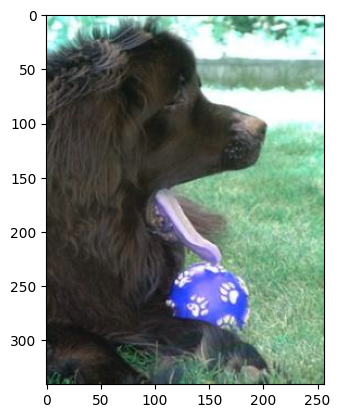

In [9]:
# 初始化ORB特征检测器对象 (chatgpt)
orb = cv2.ORB_create(nfeatures=500, scaleFactor=1.2, nlevels=8, edgeThreshold=15)
im=cv2.imread(image_paths_train[1])
plt.imshow(im)

## Function for plotting keypoints

In [10]:
def draw_keypoints(vis, keypoints, color = (0, 255, 255)):
    for kp in keypoints:
            x, y = kp.pt
            plt.imshow(cv2.circle(vis, (int(x), int(y)), 2, color))

## Plotting the keypoints

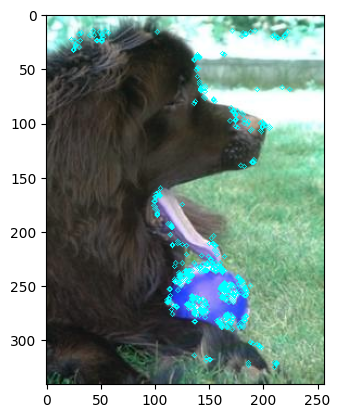

In [ ]:
kp, des = orb.detectAndCompute(im, None)
img=draw_keypoints(im,kp)

# Appending descriptors of the training images in list

In [ ]:
import cv2
import multiprocessing

def process_image(image_path):
    im=cv2.imread(image_path)
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    equalized = cv2.equalizeHist(gray)
    blur = cv2.GaussianBlur(equalized, (5, 5), 0)
    keypoints, descriptor = orb.detectAndCompute(blur, None)
    return (image_path, descriptor)

if __name__ == '__main__':
    des_list = []
    num_processes = 16 # 設定使用的進程數量，可以根據電腦配置調整
    with multiprocessing.Pool(processes=num_processes) as pool:
        results = pool.map(process_image, image_paths_train)
    des_list = results

In [ ]:
print(len(des_list[0][1]))

500


In [ ]:
descriptors=des_list[0][1]
descriptors = np.concatenate([descriptor for _, descriptor in des_list[1:]], axis=0)
descriptors_float=np.array(descriptors).astype(float)

# Performing K Means clustering on Descriptors

In [ ]:
from scipy.cluster.vq import kmeans,vq
from sklearn.cluster import MiniBatchKMeans

In [16]:
# chatgpt 
k = 500
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=1024, max_iter=120000).fit(descriptors_float)
voc = kmeans.cluster_centers_
variance = kmeans.inertia_

/home/tailab_paipei/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


#### Creating histogram of training image

In [17]:
im_features=np.zeros((len(des_list),k),"float32")
for i in range(len(des_list)):
    words, _ = vq(des_list[i][1], voc)

    # 使用bincount函数计算单个图像中每个单词出现的次数，并将结果存储到im_features数组中
    im_features[i] = np.bincount(words, minlength=k)

### Applying standardisation on training feature

In [18]:
from sklearn.preprocessing import StandardScaler
stdslr=StandardScaler().fit(im_features)
im_features=stdslr.transform(im_features)

### Create testing image feature 

In [19]:
if __name__ == '__main__':
    des_list_test = []
    num_processes = 16 # 設定使用的進程數量，可以根據電腦配置調整
    with multiprocessing.Pool(processes=num_processes) as pool:
        results = pool.map(process_image, image_paths_test)
    des_list_test = results

In [20]:
im_features_test=np.zeros((len(des_list_test),k),"float32")
for i in range(len(des_list_test)):
    words, _ = vq(des_list_test[i][1], voc)

    # 使用bincount函数计算单个图像中每个单词出现的次数，并将结果存储到im_features数组中
    im_features_test[i] = np.bincount(words, minlength=k)
im_features_test=stdslr.transform(im_features_test)

### Create validation image feature 

In [21]:
if __name__ == '__main__':
    des_list_val = []
    num_processes = 16 # 設定使用的進程數量，可以根據電腦配置調整
    with multiprocessing.Pool(processes=num_processes) as pool:
        results = pool.map(process_image, image_paths_val)
    des_list_val = results

In [22]:
im_features_val=np.zeros((len(des_list_val),k),"float32")
for i in range(len(des_list_val)):
    words, _ = vq(des_list_val[i][1], voc)

    # 使用bincount函数计算单个图像中每个单词出现的次数，并将结果存储到im_features数组中
    im_features_val[i] = np.bincount(words, minlength=k)
im_features_val=stdslr.transform(im_features_val)

# NN Training

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [25]:
device=(torch.device('cuda'))
print(f"Training on device {device}.")

Training on device cuda.


In [26]:
# 定义 MyDataset 类
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]
        return x, y

In [27]:
# 定义 MyNet 类
class MyNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MyNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [28]:
# 定义 MyNet 类
class MyNetDrop(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MyNetDrop, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [34]:
class MyNetDrop_deep(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MyNetDrop_deep, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.dropout(out)
        out = self.fc4(out)
        return out


In [30]:
# load training data
data = im_features
labels = np.array(y_train)
dataset = MyDataset(data, labels)
train_dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

In [31]:
# load validtion data
data = im_features_val
labels = np.array(y_val)
dataset = MyDataset(data, labels)
val_dataloader = DataLoader(dataset, shuffle=True)

In [32]:
# load testing data
data = im_features_test
labels = np.array(y_test)
dataset = MyDataset(data, labels)
test_dataloader = DataLoader(dataset, shuffle=True)

In [35]:
# 定义损失函数和优化器
model = MyNetDrop_deep(input_size=k, hidden_size=32, num_classes=50).to(device=device) #128
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.01)
# 创建 SummaryWriter 对象，并指定日志文件的存储路径
writer = SummaryWriter('log/logs_batch512_hd32_drop0_deep/train')

2023-03-14 21:03:02.964650: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 21:03:03.432499: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/tailab_paipei/.local/lib/python3.8/site-packages/cv2/../../lib64:
2023-03-14 21:03:03.432563: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/tailab_paipei/.local/lib/python3.8/site-packages/cv2

In [36]:
num_epochs = 300
for epoch in range(num_epochs):
    # 訓練模式
    model.train() 
    for i, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 計算訓練準確率
        _, predicted = torch.max(outputs.data, 1)
        accuracy = (predicted == labels).sum().item() / labels.size(0)

        # 訓練結果輸出
        # if i+1==len(train_dataloader):
        #     print('Epoch [{}/{}], Step [{}/{}], Training Loss: {:.4f}, Training Accuracy: {:.2%}'
        #           .format(epoch+1, num_epochs, i+1, len(train_dataloader), loss.item(), accuracy))
    
    # 驗證模式
    model.eval() 
    with torch.no_grad():
        val_loss, val_accuracy = 0, 0
        for j, (val_images, val_labels) in enumerate(val_dataloader):
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)
            val_outputs = model(val_images)
            val_loss += criterion(val_outputs, val_labels).item()

            # 計算驗證準確率
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_accuracy += (val_predicted == val_labels).sum().item() / val_labels.size(0)
            

        # 計算平均驗證損失和準確率
        val_loss /= len(val_dataloader)
        val_accuracy /= len(val_dataloader)
        # 將訓練損失和準確率寫入TensorBoard日誌文件中
        writer.add_scalar('train_loss', loss.item(), epoch)
        writer.add_scalar('train_accuracy', accuracy, epoch)
        # writer.add_scalar('train_accuracy', accuracy, epoch * len(train_dataloader) + i)
        # 將驗證損失和準確率寫入TensorBoard日誌文件中
        writer.add_scalar('val_loss', val_loss, epoch)
        writer.add_scalar('val_accuracy', val_accuracy, epoch)

        # 驗證結果輸出
        # print('Epoch [{}/{}], Validation Loss: {:.4f}, Validation Accuracy: {:.2%}'
        #       .format(epoch+1, num_epochs, val_loss, val_accuracy))

    # 測試模式
    model.eval()
    with torch.no_grad():
        # 計算測試集準確率
        test_loss, test_accuracy = 0, 0
        for k, (test_images, test_labels) in enumerate(test_dataloader):
            test_images = test_images.to(device)
            test_labels = test_labels.to(device)
            test_outputs = model(test_images)
            test_loss += criterion(test_outputs, test_labels).item()

            # 計算測試集準確率
            _, test_predicted = torch.max(test_outputs.data, 1)
            test_accuracy += (test_predicted == test_labels).sum().item() / test_labels.size(0)
        
        # 計算平均測試損失和準確率
        test_loss /= len(test_dataloader)
        test_accuracy /= len(test_dataloader)
        # 將測試損失和準確率寫入TensorBoard日誌文件中
        writer.add_scalar('test_loss', test_loss, epoch)
        writer.add_scalar('test_accuracy', test_accuracy, epoch)

# 關閉 SummaryWriter 對象
writer.close()

In [37]:
print(accuracy)
print(val_accuracy)
print(test_accuracy)

0.07736389684813753
0.06222222222222222
0.10666666666666667


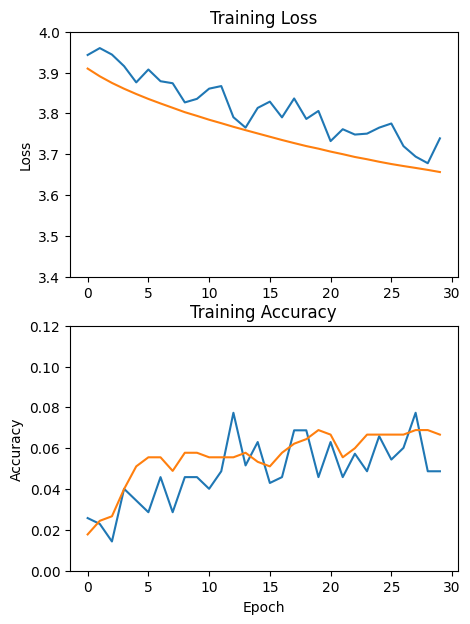

In [35]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

# 讀取log檔案
log_path = "log/logs_batch512_hd32_drop0/train"
event_acc = EventAccumulator(log_path)
event_acc.Reload()

# 取得損失值的資料
train_loss = []
for scalar_event in event_acc.Scalars("train_loss"):
    train_loss.append((scalar_event.step, scalar_event.value))
    
train_accdata = []
for scalar_event in event_acc.Scalars("train_accuracy"):
    train_accdata.append((scalar_event.step, scalar_event.value))
    
# 取得validation損失值的資料
val_loss = []
for scalar_event in event_acc.Scalars("val_loss"):
    val_loss.append((scalar_event.step, scalar_event.value))

val_accdata = []
for scalar_event in event_acc.Scalars("val_accuracy"):
    val_accdata.append((scalar_event.step, scalar_event.value))
    
# 將損失值用plt.plot()繪製出來
f = plt.figure(figsize=(5,7), dpi=100)
ax = f.add_subplot(211)
plt.plot(*zip(*train_loss), label="Training data")
plt.plot(*zip(*val_loss), label="Validation data")
# 設定圖表標題及軸標籤
plt.title("Training Loss")
# plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim([3.4, 4])
ax = f.add_subplot(212)
plt.plot(*zip(*train_accdata), label="Training data")
plt.plot(*zip(*val_accdata), label="Validation data")

# 設定圖表標題及軸標籤
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0, 0.12])
# 顯示圖表
# plt.legend()
plt.show()



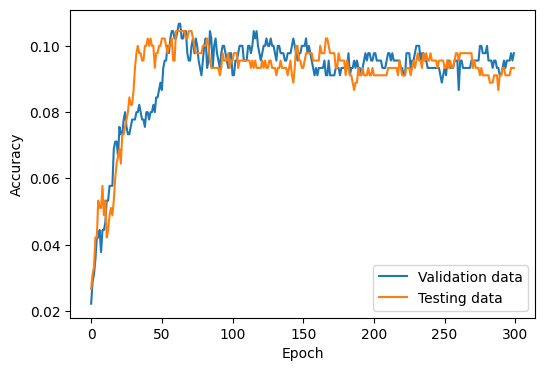

In [34]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

# 讀取log檔案
log_path = "log/logs_batch512_hd32_drop0/train"
event_acc = EventAccumulator(log_path)
event_acc.Reload()

# 取得validation損失值的資料
val_loss = []
for scalar_event in event_acc.Scalars("val_loss"):
    val_loss.append((scalar_event.step, scalar_event.value))

val_accdata = []
for scalar_event in event_acc.Scalars("val_accuracy"):
    val_accdata.append((scalar_event.step, scalar_event.value))
    
test_loss = []
for scalar_event in event_acc.Scalars("test_loss"):
    test_loss.append((scalar_event.step, scalar_event.value))

test_accdata = []
for scalar_event in event_acc.Scalars("test_accuracy"):
    test_accdata.append((scalar_event.step, scalar_event.value))
    
f = plt.figure(figsize=(6,4), dpi=100)
plt.plot(*zip(*val_accdata), label="Validation data")
plt.plot(*zip(*test_accdata), label="Testing data")
# 設定圖表標題及軸標籤
# plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
# plt.ylim([0, 0.12])
# 顯示圖表
plt.legend()
plt.show()
